# SWAG-Diagonal

[A simple baseline for bayesian uncertainty in deep learning](https://arxiv.org/abs/1902.02476) suggests the bayesian inference using stochastic weight averaging(SWA) with Gaussian-modeled weights(SWAG).


## SWA weights based on model averaging
SWA use the average value of the weights over the training epochs.
$$\theta_{SWA} = \frac{1}{T} \sum_{i=1}^{T} \theta_i$$

## Diagonal covariance of SWAG weights
To get gaussian-modeled weights for bayesian inference, we have to define the covariance of them.
$$ \bar{\theta^2} = \frac{1}{T} \sum_{i=1}^{T} \theta^2_i \\$$
$$\Sigma_{diag} = diag(\bar{\theta^2} - \theta^2_{SWA})$$

## Suggested bayesian weight
$$\mathcal{N}(\theta_{SWA}, \Sigma_{Diag})$$

Note that this notebook deals with one scalar parameter. In practice, we will adapt this for vectors of weights.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
matplotlib.style.use('ggplot')

# Uncertainty of unstable weight

In [20]:
length = 100
theta = np.random.randn(length) + np.array(list(map(lambda x:x*(x-20), range(-length//2,length//2))))/length
#theta = np.random.randn(length) + np.arange(length)/100

theta_swa = []
theta_bar_square = []

for i in range(len(theta)):
    sum_theta = 0
    sum_theta_square = 0
    for j in range(i+1):
        sum_theta += theta[j]
        sum_theta_square += theta[j]*theta[j]
    theta_swa.append(sum_theta/(i+1))
    theta_bar_square.append(sum_theta_square/(i+1))
    
theta_bar_square = np.array(theta_bar_square)
theta_swa_square = np.array(list(map(lambda x:x*x, theta_swa)))

var = np.sqrt(np.abs(theta_bar_square - theta_swa_square))

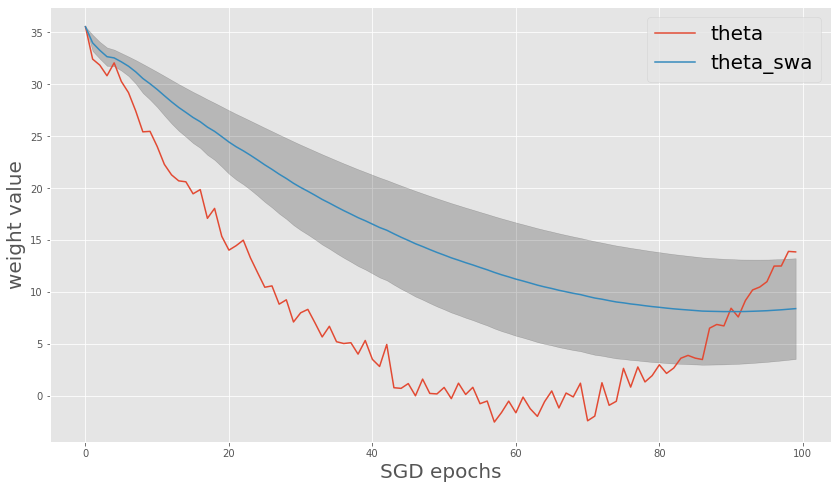

In [21]:
fig = plt.figure(figsize=(14,8))
plt.plot(theta)
plt.plot(theta_swa)
plt.fill_between(range(length),theta_swa-var/2, theta_swa+var/2, color='black', alpha=0.2)
plt.xlabel("SGD epochs", fontsize=20)
plt.ylabel("weight value", fontsize=20)
plt.legend(["theta", "theta_swa"], fontsize=20)
plt.savefig('theta_swa.png', dpi=300)

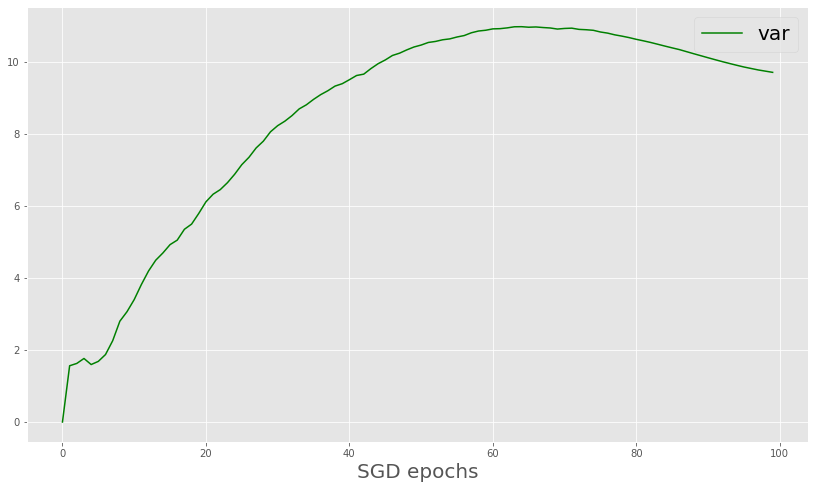

In [22]:
fig = plt.figure(figsize=(14,8))
plt.plot(var, color='g')
plt.xlabel("SGD epochs", fontsize=20)
plt.legend(["var"], fontsize=20)
plt.savefig('var.png', dpi=300)

## At the end of the day, we will make 1-dimensional Gaussian for a weight using the final variance

# Uncertainty of converged weight

In [105]:
length = 100
#theta = np.random.randn(length) + np.array(list(map(lambda x:x*(x-120), range(-length//2,length//2))))/length
theta = np.random.randn(length)/np.arange(1,length+1) #+ np.arange(length)/100

theta_swa = []
theta_bar_square = []

for i in range(len(theta)):
    sum_theta = 0
    sum_theta_square = 0
    for j in range(i+1):
        sum_theta += theta[j]
        sum_theta_square += theta[j]*theta[j]
    theta_swa.append(sum_theta/(i+1))
    theta_bar_square.append(sum_theta_square/(i+1))
    
theta_bar_square = np.array(theta_bar_square)
theta_swa_square = np.array(list(map(lambda x:x*x, theta_swa)))

var = np.sqrt(np.abs(theta_bar_square - theta_swa_square))

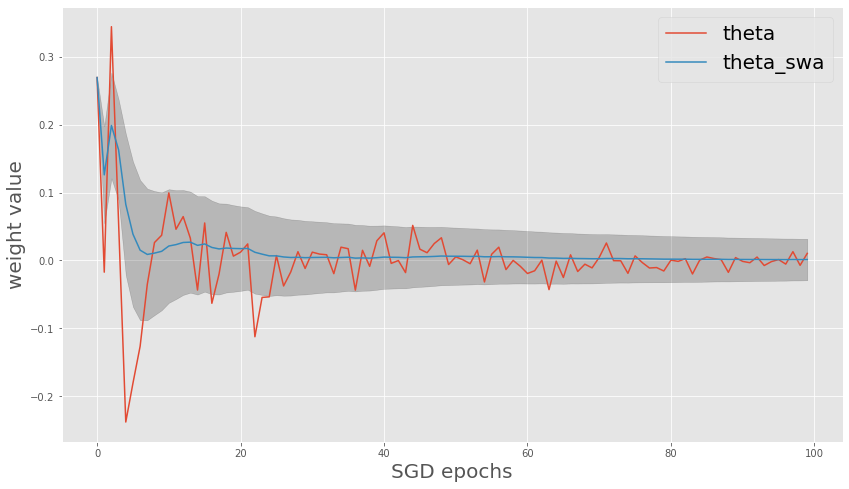

In [106]:
fig = plt.figure(figsize=(14,8))
plt.plot(theta)
plt.plot(theta_swa)
plt.fill_between(range(length),theta_swa-var/2, theta_swa+var/2, color='black', alpha=0.2)
plt.xlabel("SGD epochs", fontsize=20)
plt.ylabel("weight value", fontsize=20)
plt.legend(["theta", "theta_swa"], fontsize=20)
plt.savefig('theta_swa_converge.png', dpi=300)

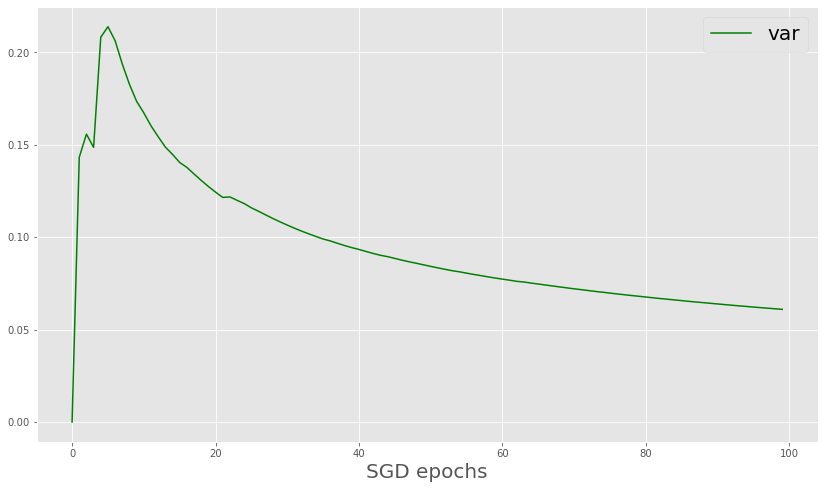

In [107]:
fig = plt.figure(figsize=(14,8))
plt.plot(var, color='g')
plt.xlabel("SGD epochs", fontsize=20)
plt.legend(["var"], fontsize=20)
plt.savefig('var_converge.png', dpi=300)

# SWAG full covariance with 2-dim weights

Although the diagonal covariance approximation is standard in Bayesian deep learning, the author suggest the full-covariance matrix since the diagonal can be too restrictive.

## The full covariance matrix

$$\Sigma = \frac{1}{T-1} \sum^T_{i=1}(\theta_i - \theta_{SWA})(\theta_i - \theta_{SWA})^T$$
Where T is the number of epochs

But we cannot access into $\theta_{SWA}$ during the epoch since the $\theta_{SWA}$ can be calculated in the T'th epoch. So we approximate as

$$\Sigma = \frac{1}{T-1} \sum^T_{i=1}(\theta_i - \bar{\theta_i})(\theta_i - \bar{\theta_i})^T$$
Where $\bar{\theta_i}$ is the running estimate of the parameters' mean obtained from the first $i$ samples.

## The final distribution for sampling weights

$$\mathcal{N}(\theta_{SWA}, (\Sigma_{diag} + \Sigma_{full})/2)$$

## Low-rank covariance
Authors also suggest low-rank covariance that only take the last $K$ observations of weights,
$$\Sigma_{lowrank} = \frac{1}{K} \sum_{[T-K:T]}(\theta_i - \bar{\theta_i})(\theta_i - \bar{\theta_i})^T$$

<Figure size 288x288 with 0 Axes>

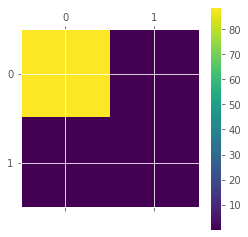

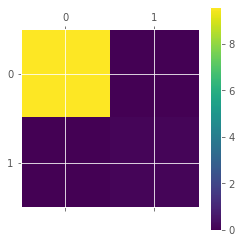

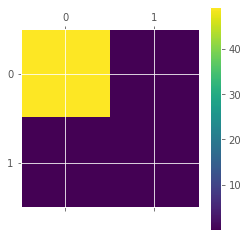

In [146]:
theta1 = np.random.randn(length) + np.array(list(map(lambda x:x*(x-20), range(-length//2,length//2))))/length
theta2 = np.random.randn(length)/np.arange(1,length+1) #+ np.arange(length)/100

params = np.concatenate((np.expand_dims(theta1,0), np.expand_dims(theta2,0)), axis=0).transpose()

theta1_swa = []
theta2_swa = []

theta1_bar_square = []
theta2_bar_square = []

for i in range(len(theta)):
    sum_theta1 = 0
    sum_theta2 = 0
    sum_theta1_square = 0
    sum_theta2_square = 0
    for j in range(i+1):
        sum_theta1 += theta1[j]
        sum_theta2 += theta2[j]
        sum_theta1_square += theta1[j] * theta1[j]
        sum_theta2_square += theta2[j] * theta2[j]
    theta1_swa.append(sum_theta1/(i+1))
    theta1_bar_square.append(sum_theta1_square/(i+1))
    theta2_swa.append(sum_theta2/(i+1))
    theta2_bar_square.append(sum_theta2_square/(i+1))

### Calculate digonal cov
theta1_bar_square = np.array(theta1_bar_square)
theta1_swa_square = np.array(list(map(lambda x:x*x, theta1_swa)))
var1 = np.sqrt(np.abs(theta1_bar_square - theta1_swa_square))

theta2_bar_square = np.array(theta2_bar_square)
theta2_swa_square = np.array(list(map(lambda x:x*x, theta2_swa)))
var2 = np.sqrt(np.abs(theta2_bar_square - theta2_swa_square))

cov_diag_per_epoch = np.array(list(map(np.diag,np.concatenate(([var1],[var2])).transpose())))

### Calculate Full cov
params_swa = np.concatenate(([theta1_swa], [theta2_swa]), axis=0).transpose()
cov_full = np.zeros((2,2))
cov_full_per_epoch = []
cov_full_per_epoch.append(cov_full)
t = 1
for p_i, p_swa_i in zip(params,params_swa):
    D_i = p_i - p_swa_i
    cov_full += D_i.reshape(2,1)@D_i.reshape(1,2)
    if t >= 2:
        cov_full_per_epoch.append(cov/t)
    t += 1
cov_full_per_epoch = np.array(cov_full_per_epoch)

### Full cov + Diag cov
cov_per_epoch = cov_full_per_epoch/2 + cov_diag_per_epoch/2

fig = plt.figure(figsize=(4,4))
plt.matshow(cov_full_per_epoch[-1])
plt.colorbar()
plt.matshow(cov_diag_per_epoch[-1])
plt.colorbar()
plt.matshow(cov_per_epoch[-1])
plt.colorbar()
plt.show()

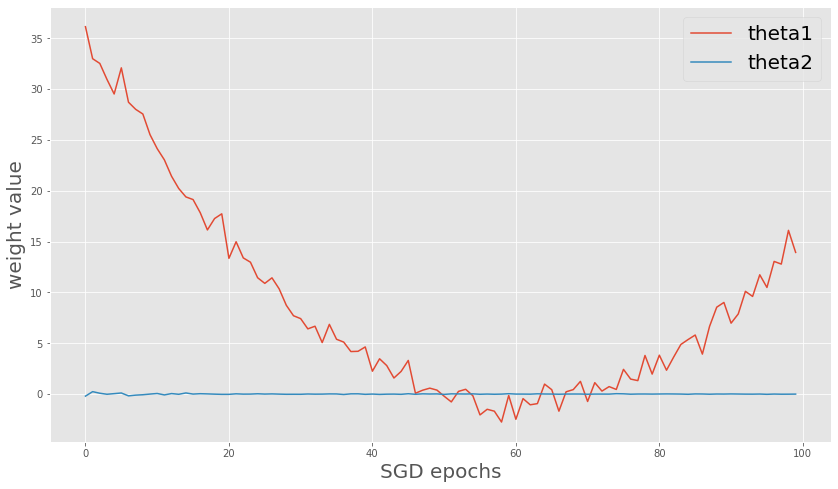

In [113]:
fig = plt.figure(figsize=(14,8))
plt.plot(theta1)
plt.plot(theta2)
plt.xlabel("SGD epochs", fontsize=20)
plt.ylabel("weight value", fontsize=20)
plt.legend(["theta1", "theta2"], fontsize=20)
plt.show()

# Bayesian inference with SWAG weights

## MAP optimization

We can maximize log posterior:
$$log p(\theta|\mathcal{D}) = log p(\mathcal{D}|\theta) + log p(\theta)$$
We can consider the prior $p(\theta)$ as the regularizer in optimization (L1, L2). But it is not Bayesian inference since the maximum posterior $\hat{\theta_{MAP}}$ is determined so we cannot get non-deterministic outputs (without uncertainty predictions).

## Marginalized predictive distribution
So we marginalizes the posterior distribution over all possible $\theta$.
$$p(y|\mathcal{D},x) = \int p(y|\theta,x) p(\theta|\mathcal{D})$$
In practice, we can approximate this intractable value with Monte carlo sampling.
$$p(y|\mathcal{D},x) \approx \frac{1}{T} \sum_{t} p(y|\theta_t,x)$$
$$ \follow p(\theta|\mathcal{D})$$
